In [1]:
from platform import python_version
print(python_version())

3.6.3


In [2]:
import sys
sys.executable

'/home/ankish1/anaconda3/envs/tensor/bin/python'

In [3]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

/home/ankish1/anaconda3/envs/tensor/bin/python
3.6.3 |Anaconda, Inc.| (default, Nov 20 2017, 20:41:42) 
[GCC 7.2.0]
sys.version_info(major=3, minor=6, micro=3, releaselevel='final', serial=0)


0016E5_08430.png
seg.shape=(360, 480, 3), img_is.shape=(360, 480, 3)
minimum seg = 0, maximum seg = 11, Total number of segmentation classes = 12


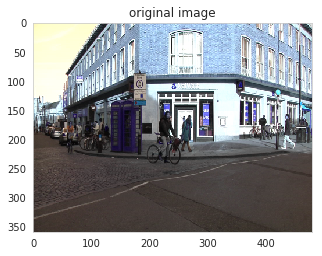

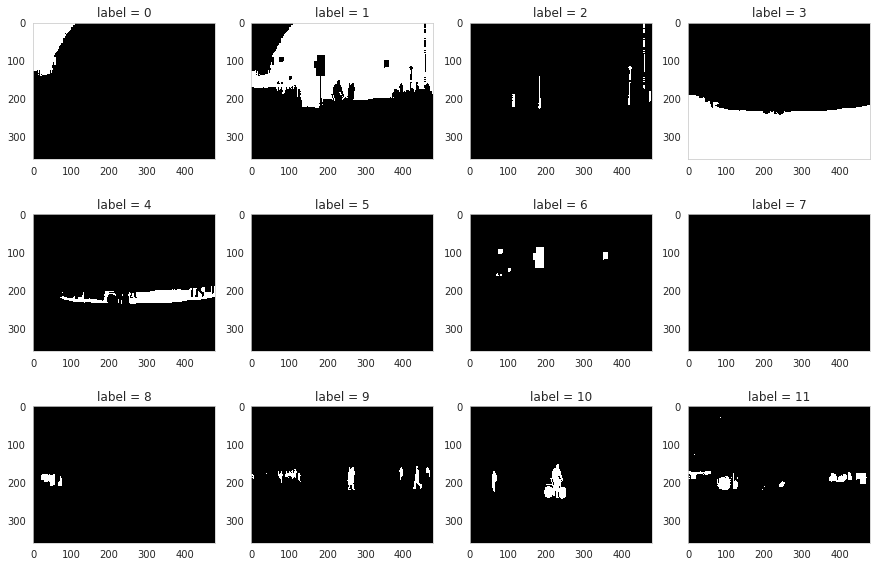

In [4]:
dir_data = "dataset1/"
dir_seg = dir_data + "/annotations_prepped_train/"
dir_img = dir_data + "/images_prepped_train/"

import cv2, os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
## seaborn has white grid by default so I will get rid of this.
sns.set_style("whitegrid", {'axes.grid' : False})


ldseg = np.array(os.listdir(dir_seg))
## pick the first image file
fnm = ldseg[0]
print(fnm)

## read in the original image and segmentation labels
seg = cv2.imread(dir_seg + fnm ) # (360, 480, 3)
img_is = cv2.imread(dir_img + fnm )
print("seg.shape={}, img_is.shape={}".format(seg.shape,img_is.shape))

## Check the number of labels
mi, ma = np.min(seg), np.max(seg)
n_classes = ma - mi + 1
print("minimum seg = {}, maximum seg = {}, Total number of segmentation classes = {}".format(mi,ma, n_classes))

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.imshow(img_is)
ax.set_title("original image")
plt.show()

fig = plt.figure(figsize=(15,10))
for k in range(mi,ma+1):
    ax = fig.add_subplot(3,n_classes/3,k+1)
    ax.imshow((seg == k)*1.0)
    ax.set_title("label = {}".format(k))


plt.show()



In [5]:
plt.imread(dir_img + fnm).shape, plt.imread(dir_seg + fnm).shape

((360, 480, 3), (360, 480))

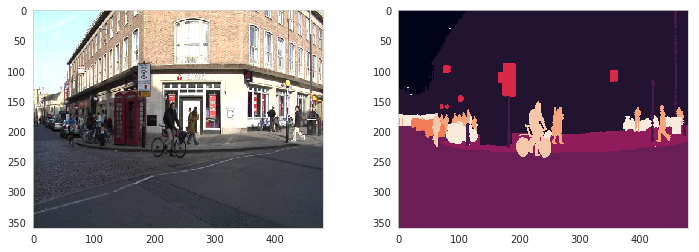

In [6]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].imshow(plt.imread(dir_img + fnm))
ax[1].imshow(plt.imread(dir_seg + fnm))

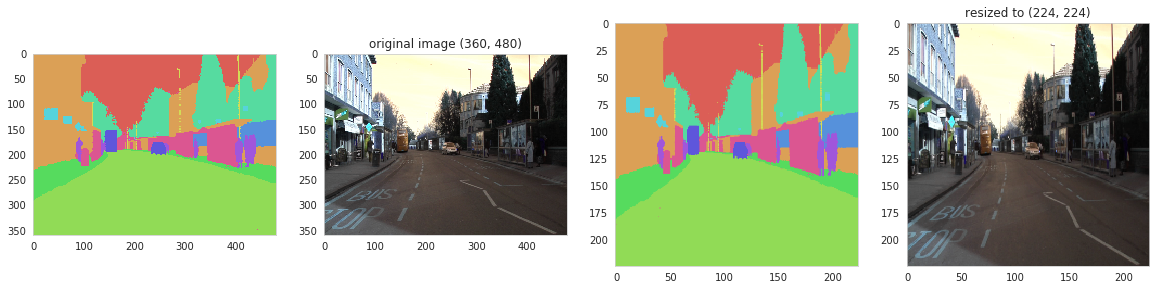

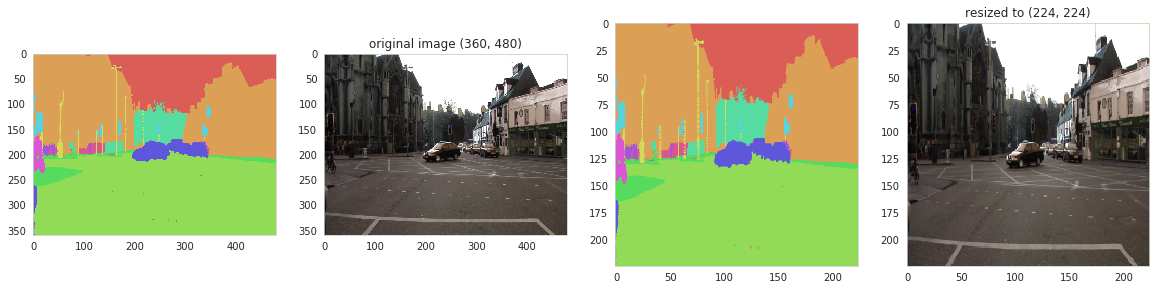

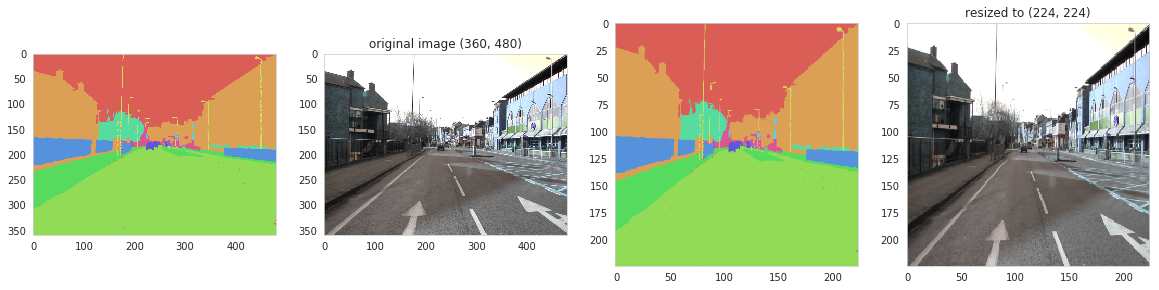

In [8]:
import random
def give_color_to_seg_img(seg,n_classes):
    '''
    seg : (input_width,input_height,3)
    '''
    
    if len(seg.shape)==3:
        seg = seg[:,:,0]
    seg_img = np.zeros( (seg.shape[0],seg.shape[1],3) ).astype('float')
    colors = sns.color_palette("hls", n_classes)
    
    for c in range(n_classes):
        segc = (seg == c)
        seg_img[:,:,0] += (segc*( colors[c][0] ))
        seg_img[:,:,1] += (segc*( colors[c][1] ))
        seg_img[:,:,2] += (segc*( colors[c][2] ))

    return(seg_img)

input_height , input_width = 224 , 224
output_height , output_width = 224 , 224


ldseg = np.array(os.listdir(dir_seg))
for fnm in ldseg[np.random.choice(len(ldseg),3,replace=False)]:
    fnm = fnm.split(".")[0]
    seg = cv2.imread(dir_seg + fnm + ".png") # (360, 480, 3)
    img_is = cv2.imread(dir_img + fnm + ".png")
    seg_img = give_color_to_seg_img(seg,n_classes)

    fig = plt.figure(figsize=(20,40))
    ax = fig.add_subplot(1,4,1)
    ax.imshow(seg_img)
    
    ax = fig.add_subplot(1,4,2)
    ax.imshow(img_is/255.0)
    ax.set_title("original image {}".format(img_is.shape[:2]))
    
    ax = fig.add_subplot(1,4,3)
    ax.imshow(cv2.resize(seg_img,(input_height , input_width)))
    
    ax = fig.add_subplot(1,4,4)
    ax.imshow(cv2.resize(img_is,(output_height , output_width))/255.0)
    ax.set_title("resized to {}".format((output_height , output_width)))
    plt.show()

In [9]:
## Import usual libraries
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
import keras, sys, time, warnings
from keras.models import *
from keras.layers import *
import pandas as pd 
from keras.utils import plot_model 

warnings.filterwarnings("ignore")

# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.95
# config.gpu_options.visible_device_list = "2" 
# set_session(tf.Session(config=config))   

print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__)); del keras
print("tensorflow version {}".format(tf.__version__))


python 3.6.3 |Anaconda, Inc.| (default, Nov 20 2017, 20:41:42) 
[GCC 7.2.0]
keras version 2.2.4
tensorflow version 1.12.0


Using TensorFlow backend.


In [17]:
def FCN8( nClasses ,  input_height=224, input_width=224):
    ## input_height and width must be devisible by 32 because maxpooling with filter size = (2,2) is operated 5 times,
    ## which makes the input_height and width 2^5 = 32 times smaller
    assert input_height%32 == 0
    assert input_width%32 == 0
    IMAGE_ORDERING =  "channels_last" 

    img_input = Input(shape=(input_height,input_width, 3)) ## Assume 224,224,3
    
    ## Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1' )(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2' )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool' )(x)
    f1 = x
    
    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1' )(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2' )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool' )(x)
    f2 = x

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1' )(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2' )(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3' )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool' )(x)
    pool3 = x

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1' )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2' )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3' )(x)
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool' )(x)## (None, 14, 14, 512) 

    # Block 5
#     x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1' )(pool4)
#     x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2' )(x)
#     x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3' )(x)
#     pool5 = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool' )(x)## (None, 7, 7, 512)

#     x = Flatten(name='flatten')(x)
#     x = Dense(4096, activation='relu', name='fc1')(x)
#     <--> o = ( Conv2D( 4096 , ( 7 , 7 ) , activation='relu' , padding='same', data_format=IMAGE_ORDERING))(o)
#     assuming that the input_height = input_width = 224 as in VGG data
    
#     x = Dense(4096, activation='relu', name='fc2')(x)
#     <--> o = ( Conv2D( 4096 , ( 1 , 1 ) , activation='relu' , padding='same', data_format=IMAGE_ORDERING))(o)   
#     assuming that the input_height = input_width = 224 as in VGG data
    
#     x = Dense(1000 , activation='softmax', name='predictions')(x)
#     <--> o = ( Conv2D( nClasses ,  ( 1 , 1 ) ,kernel_initializer='he_normal' , data_format=IMAGE_ORDERING))(o)
#     assuming that the input_height = input_width = 224 as in VGG data
    
    
#     vgg  = Model(  img_input , pool5  )
#     vgg.load_weights(VGG_Weights_path) ## loading VGG weights for the encoder parts of FCN8
    
    n = 512
    o = ( Conv2D( n , ( 7 , 7 ) , activation='relu' , padding='same', name="conv6"))(pool4)
    conv7 = ( Conv2D( n , ( 1 , 1 ) , activation='relu' , padding='same', name="conv7"))(o)
    
    
    ## 4 times upsamping for pool4 layer
    conv7_4 = Conv2DTranspose( nClasses , kernel_size=(4,4) ,  strides=(4,4) , use_bias=False )(conv7)
    ## (None, 224, 224, 10)
    ## 2 times upsampling for pool411
    pool411 = ( Conv2D( nClasses , ( 1 , 1 ) , activation='relu' , padding='same', name="pool4_11"))(pool4)
    pool411_2 = (Conv2DTranspose( nClasses , kernel_size=(2,2) ,  strides=(2,2) , use_bias=False ))(pool411)
    
    pool311 = ( Conv2D( nClasses , ( 1 , 1 ) , activation='relu' , padding='same', name="pool3_11"))(pool3)
        
    o = Add(name="add")([pool411_2, pool311, conv7_4 ])
    o = Conv2DTranspose( nClasses , kernel_size=(8,8) ,  strides=(8,8) , use_bias=False )(o)
    o = (Activation('softmax'))(o)
    
    model = Model(img_input, o)

    return model

model = FCN8(nClasses     = n_classes,  
             input_height = 224, 
             input_width  = 224)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_5[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [9]:
def FCN8( nClasses ,  input_height=224, input_width=224):
    ## input_height and width must be devisible by 32 because maxpooling with filter size = (2,2) is operated 5 times,
    ## which makes the input_height and width 2^5 = 32 times smaller
    assert input_height%32 == 0
    assert input_width%32 == 0
    IMAGE_ORDERING =  "channels_last" 

    img_input = Input(shape=(input_height,input_width, 3)) ## Assume 224,224,3
    
    ## Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', data_format=IMAGE_ORDERING )(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2', data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool', data_format=IMAGE_ORDERING )(x)
    f1 = x
    
    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2', data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool', data_format=IMAGE_ORDERING )(x)
    f2 = x

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3', data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool', data_format=IMAGE_ORDERING )(x)
    pool3 = x

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3', data_format=IMAGE_ORDERING )(x)
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool', data_format=IMAGE_ORDERING )(x)## (None, 14, 14, 512) 

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1', data_format=IMAGE_ORDERING )(pool4)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3', data_format=IMAGE_ORDERING )(x)
    pool5 = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool', data_format=IMAGE_ORDERING )(x)## (None, 7, 7, 512)

    #x = Flatten(name='flatten')(x)
    #x = Dense(4096, activation='relu', name='fc1')(x)
    # <--> o = ( Conv2D( 4096 , ( 7 , 7 ) , activation='relu' , padding='same', data_format=IMAGE_ORDERING))(o)
    # assuming that the input_height = input_width = 224 as in VGG data
    
    #x = Dense(4096, activation='relu', name='fc2')(x)
    # <--> o = ( Conv2D( 4096 , ( 1 , 1 ) , activation='relu' , padding='same', data_format=IMAGE_ORDERING))(o)   
    # assuming that the input_height = input_width = 224 as in VGG data
    
    #x = Dense(1000 , activation='softmax', name='predictions')(x)
    # <--> o = ( Conv2D( nClasses ,  ( 1 , 1 ) ,kernel_initializer='he_normal' , data_format=IMAGE_ORDERING))(o)
    # assuming that the input_height = input_width = 224 as in VGG data
    
    
    vgg  = Model(  img_input , pool5  )
#     vgg.load_weights(VGG_Weights_path) ## loading VGG weights for the encoder parts of FCN8
    
    n = 4096
    o = ( Conv2D( n ,(7 , 7), activation='relu' , padding='same', name="conv6", data_format=IMAGE_ORDERING))(pool5)
    conv7 = ( Conv2D(n ,(1 ,1 ), activation='relu' , padding='same', name="conv7", data_format=IMAGE_ORDERING))(o)
    
    
    ## 4 times upsamping for pool4 layer
    conv7_4 = Conv2DTranspose( nClasses , kernel_size=(4,4) ,  strides=(4,4) , use_bias=False, data_format=IMAGE_ORDERING )(conv7)
    ## (None, 224, 224, 10)
    ## 2 times upsampling for pool411
    pool411 = ( Conv2D( nClasses , ( 1 , 1 ) , activation='relu' , padding='same', name="pool4_11", data_format=IMAGE_ORDERING))(pool4)
    pool411_2 = (Conv2DTranspose( nClasses , kernel_size=(2,2) ,  strides=(2,2) , use_bias=False, data_format=IMAGE_ORDERING ))(pool411)
    
    pool311 = ( Conv2D( nClasses , ( 1 , 1 ) , activation='relu' , padding='same', name="pool3_11", data_format=IMAGE_ORDERING))(pool3)
        
    o = Add(name="add")([pool411_2, pool311, conv7_4 ])
    o = Conv2DTranspose( nClasses , kernel_size=(8,8) ,  strides=(8,8) , use_bias=False, data_format=IMAGE_ORDERING )(o)
    o = (Activation('softmax'))(o)
    
    model = Model(img_input, o)

    return model

model = FCN8(nClasses     = n_classes,  
             input_height = 224, 
             input_width  = 224)
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [15]:
# plot_model(model, to_file='fcn8.png') 

In [10]:
from keras.applications.mobilenet import MobileNet

input_image = Input(shape=(224,224,3))
224
mobilenet = MobileNet(input_shape=(224,224,3), include_top=False, weights=None)
mobilenet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

In [14]:
model_ = Model(mobilenet.input, [mobilenet.output, 
                                 mobilenet.get_layer('conv_pw_11_relu').output,
                                 mobilenet.get_layer('conv_pw_5_relu').output])

In [20]:
mobilenet.output,  mobilenet.get_layer('conv_pw_11_relu').output, mobilenet.get_layer('conv_pw_5_relu').output

(<tf.Tensor 'conv_pw_13_relu/Relu6:0' shape=(?, 7, 7, 1024) dtype=float32>,
 <tf.Tensor 'conv_pw_11_relu/Relu6:0' shape=(?, 14, 14, 512) dtype=float32>,
 <tf.Tensor 'conv_pw_5_relu/Relu6:0' shape=(?, 28, 28, 256) dtype=float32>)

In [16]:
plot_model(model_, to_file='mobilenet_feat.png')

In [22]:
n = 512
nClasses = 12
o = Conv2D(n, (7,7), activation='relu', padding='same', name="conv6")(mobilenet.output)
conv7 = Conv2D(n, (1,1), activation='relu', padding='same', name="conv7")(o)


## 4 times upsamping for pool4 layer
conv7_4 = Conv2DTranspose(nClasses, (4,4), strides=(4,4), use_bias=False )(conv7)
## (None, 224, 224, 10)
## 2 times upsampling for pool411
pool411 = Conv2D( nClasses, (1,1),activation='relu', padding='same', name="pool4_11")(mobilenet.get_layer('conv_pw_11_relu').output)
pool411_2 = Conv2DTranspose(nClasses, (2,2), strides=(2,2), use_bias=False )(pool411)

pool311 = Conv2D(nClasses, (1,1), activation='relu' , padding='same', name="pool3_11")(mobilenet.get_layer('conv_pw_5_relu').output)

o = Add(name="add")([pool411_2, pool311, conv7_4 ])
o = Conv2DTranspose( nClasses , kernel_size=(8,8) ,  strides=(8,8) , use_bias=False )(o)
o = (Activation('softmax'))(o)

model_1 = Model(mobilenet.input, o)

In [23]:
model_1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu

In [24]:
plot_model(model_1, to_file='model_1.png')

In [25]:
28*8

224

In [ ]:
from sklearn.utils import shuffle
train_rate = 0.85
index_train = np.random.choice(X.shape[0],int(X.shape[0]*train_rate),replace=False)
index_test  = list(set(range(X.shape[0])) - set(index_train))
                            
X, Y = shuffle(X,Y)
X_train, y_train = X[index_train],Y[index_train]
X_test, y_test = X[index_test],Y[index_test]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


In [ ]:
from keras import optimizers


sgd = optimizers.SGD(lr=1E-2, decay=5**(-4), momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

hist1 = model.fit(X_train,y_train,
                  validation_data=(X_test,y_test),
                  batch_size=32,epochs=200,verbose=2)


In [ ]:
or key in ['loss', 'val_loss']:
    plt.plot(hist1.history[key],label=key)
plt.legend()
plt.show()


In [ ]:
y_pred = model.predict(X_test)
y_predi = np.argmax(y_pred, axis=3)
y_testi = np.argmax(y_test, axis=3)
print(y_testi.shape,y_predi.shape)


In [ ]:
def IoU(Yi,y_predi):
    ## mean Intersection over Union
    ## Mean IoU = TP/(FN + TP + FP)

    IoUs = []
    Nclass = int(np.max(Yi)) + 1
    for c in range(Nclass):
        TP = np.sum( (Yi == c)&(y_predi==c) )
        FP = np.sum( (Yi != c)&(y_predi==c) )
        FN = np.sum( (Yi == c)&(y_predi != c)) 
        IoU = TP/float(TP + FP + FN)
        print("class {:02.0f}: #TP={:6.0f}, #FP={:6.0f}, #FN={:5.0f}, IoU={:4.3f}".format(c,TP,FP,FN,IoU))
        IoUs.append(IoU)
    mIoU = np.mean(IoUs)
    print("_________________")
    print("Mean IoU: {:4.3f}".format(mIoU))
    
IoU(y_testi,y_predi)


In [ ]:
shape = (224,224)
n_classes= 10

for i in range(10):
    img_is  = (X_test[i] + 1)*(255.0/2)
    seg = y_predi[i]
    segtest = y_testi[i]

    fig = plt.figure(figsize=(10,30))    
    ax = fig.add_subplot(1,3,1)
    ax.imshow(img_is/255.0)
    ax.set_title("original")
    
    ax = fig.add_subplot(1,3,2)
    ax.imshow(give_color_to_seg_img(seg,n_classes))
    ax.set_title("predicted class")
    
    ax = fig.add_subplot(1,3,3)
    ax.imshow(give_color_to_seg_img(segtest,n_classes))
    ax.set_title("true class")
    plt.show()